In [1]:
import numpy as np
from astropy.io import fits
import pylab as pl
import healpy as hp
from glob import glob

In [2]:
import matplotlib.colors as colors

# Check one file

In [11]:
root = "/global/cfs/cdirs/desicollab/users/lauracdp/photo-z_box/lya_mocks/mock_analysis/qq_desi_y5/skewers_desi_footprint.5/analysis-0/jura-0/"
root += "true_cont/deltas_lya/Delta/"

In [12]:
example_file = root + "delta-1375.fits.gz"
hdu=fits.open(example_file)

In [13]:
# print table information:
hdu.info

<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7ff6978a9ca0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7ff69710bd90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7ff6971f3520>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7ff69710b7c0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7ff697118220>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7ff6971183a0>]>

In [14]:
len(hdu)

6

In [7]:
for i in range(1, len(hdu)):
    print(i)
    print(hdu[i].header)
    print("\\")

1
XTENSION= 'IMAGE   '           / IMAGE extension                                BITPIX  =                  -64 / number of bits per data pixel                  NAXIS   =                    1 / number of data axes                            NAXIS1  =                 2716 / length of data axis 1                          PCOUNT  =                    0 / required keyword; must = 0                     GCOUNT  =                    1 / required keyword; must = 1                     EXTNAME = 'LAMBDA  '                                                            BUNIT   = 'Angstrom'           / wavelength units                               HIERARCH WAVE_SOLUTION = 'lin     ' / chosen wavelength solution                HIERARCH DELTA_LAMBDA =    0.8 / pixel step                                     COMMENT Wavelength grid                                                         CHECKSUM= 'VD9SYD6QVD6QVD6Q'   / HDU checksum updated 2025-02-18T22:08:15       DATASUM = '1634060384'         / data 

In [4]:
wave = hdu[1].data
ra = hdu[2].data['RA']
dec = hdu[2].data['DEC']
zqso = hdu[2].data['Z']
qid= hdu[2].data['LOS_ID']
delta = hdu[3].data
weights = hdu[4].data
cont = hdu[5].data

In [5]:
obj_ind = np.where(qid==500064150)[0][0]
print(obj_ind)

431


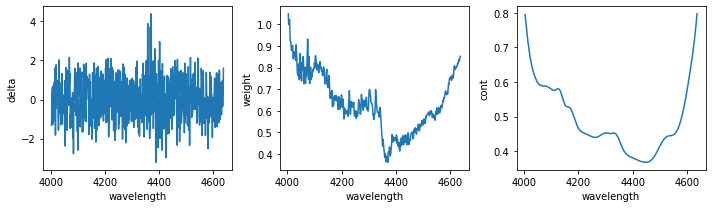

In [61]:
fig,axarr=pl.subplots(1,3,figsize=[10,3])
pl.sca(axarr[0])
pl.plot(wave, delta[obj_ind, :])
pl.xlabel("wavelength")
pl.ylabel("delta")

pl.sca(axarr[1])
pl.plot(wave, weights[obj_ind, :])
pl.xlabel("wavelength")
pl.ylabel("weight")

pl.sca(axarr[2])
pl.plot(wave, cont[obj_ind, :])
pl.xlabel("wavelength")
pl.ylabel("cont")

pl.tight_layout()

In [5]:
# inspect results from one run:
fin = fits.open("/pscratch/sd/q/qhang/desi-lya/delta_F-noise/delta-noisy-desi-footprint-chunk-0.fits")

In [6]:
fin[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   56 / length of dimension 1                          
NAXIS2  =               318261 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    7 / number of table fields                         
TTYPE1  = 'RA      '                                                            
TFORM1  = 'D       '                                                            
TTYPE2  = 'DEC     '                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'Z       '        

In [7]:
ra = fin[1].data['RA']
dec = fin[1].data['DEC']

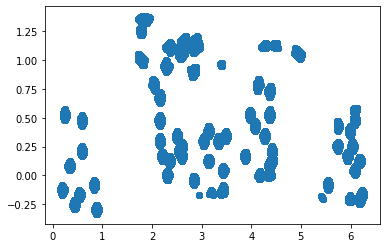

In [8]:
pl.scatter(ra, dec)

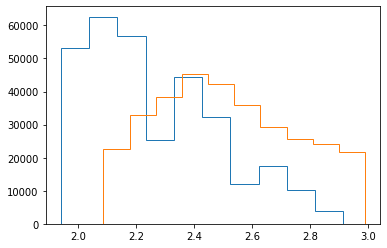

In [9]:
cc=pl.hist(fin[1].data['Z'],histtype='step')
cc=pl.hist(fin[1].data['ZQSO'],histtype='step')

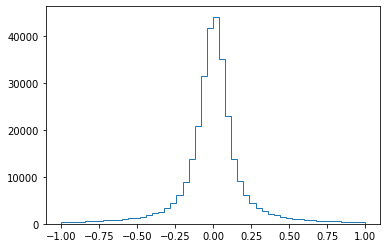

In [10]:
cc=pl.hist(fin[1].data['DELTA_F'],range=[-1,1],bins=50, histtype='step')

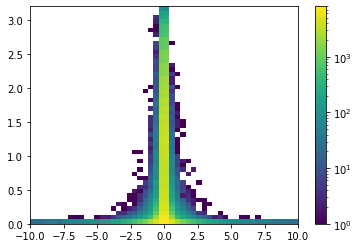

In [12]:
cc=pl.hist2d(fin[1].data['DELTA_F'], fin[1].data['TOTWEIGHTS']/fin[1].data['NPIX'],
            bins=[50,50], norm=colors.LogNorm(),range=[[-10,10],[0,3.2]])
pl.colorbar()

In [16]:
weights = fin[1].data['TOTWEIGHTS']/fin[1].data['NPIX']
print(sum(weights == 0))
print(fin[1].data['DELTA_F'][weights == 0])

36
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
# we can mask some pixels with very low weights (compare with no masking etc.)

# Check combine runs

In [17]:
# functions
def save_catalog_to_fits(fname, data_matrix):
    c=[]
    dtype_to_fits_type = {'int64': 'K',
                          'float64': 'D',
                          'float32': 'E',
                          '<U6': '20A',
                          'bool': 'bool',
                          '>f8': 'D',
                          '>f4': 'E',
                         }
    
    for ii, keys in enumerate(data_matrix.keys()):
        col=fits.Column(name=keys, array=data_matrix[keys],
                        format=dtype_to_fits_type[str(data_matrix[keys].dtype)])
        c.append(col)
    t = fits.BinTableHDU.from_columns(c)
    t.writeto(fname)


In [19]:
keys = ['RA', 'DEC', 'Z', 'ZQSO', 'DELTA_F', 'NPIX', 'TOTWEIGHTS']
data_holder = {}
for key in keys:
    data_holder[key] = np.array([])

nchunks = 16
root = "/pscratch/sd/q/qhang/desi-lya/delta_F-noise/"
for n in range(nchunks):
    fname = root +  f"delta-noisy-desi-footprint-chunk-{n}.fits"
    fin = fits.open(fname)
    for key in keys:
        data_holder[key] = np.append(data_holder[key], fin[1].data[key])

print("Number of objects in chunk: ", len(data_holder["DELTA_F"]))
# save
savename = root + "delta-noisy-desi-footprint.fits"
save_catalog_to_fits(savename, data_holder)
print(f"saved: {savename}")

Number of objects in chunk:  5164256
saved: /pscratch/sd/q/qhang/desi-lya/delta_F-noise/delta-noisy-desi-footprint.fits


# raw 

3072
529


array([1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087,
       1088, 1089, 1090, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1100,
       1101, 1102, 1103, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147,
       1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158,
       1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1204, 1205,
       1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216,
       1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227,
       1228, 1229, 1230, 1231, 1268, 1269, 1270, 1271, 1272, 1273, 1274,
       1275, 1276, 1277, 1278, 1279, 1280, 1281, 1282, 1283, 1284, 1285,
       1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1333, 1334,
       1335, 1336, 1337, 1338, 1339, 1340, 1341, 1342, 1343, 1344, 1345,
       1346, 1347, 1348, 1349, 1350, 1351, 1352, 1353, 1354, 1355, 1356,
       1357, 1358, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384,
       1397, 1398, 1399, 1400, 1401, 1402, 1403, 14

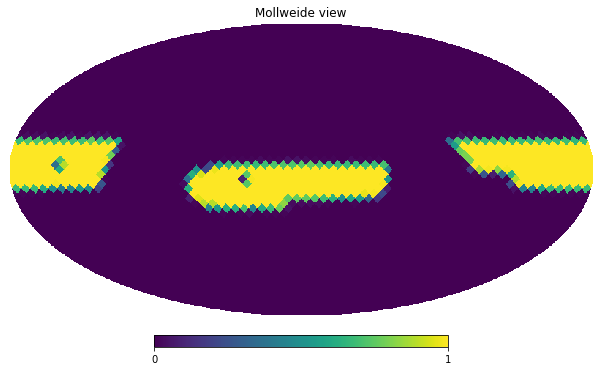

In [18]:
# figure out pixels to use:
mask = hp.read_map("/pscratch/sd/q/qhang/desi-lya/desixlsst-mask-nside-128.fits")
nside=hp.get_nside(mask)
mask_degrade = hp.ud_grade(mask, 16)
hp.mollview(mask_degrade)
print(12*16**2)
print(sum(mask_degrade.astype(bool)))
pixels_in_mask = np.arange(12*16**2)[mask_degrade.astype(bool)]
pixels_in_mask

In [25]:
fname_list[1][161:-8]

'1146'

In [28]:
fname_pix = []
for i in range(len(fname_list)):
    fname_pix.append(int(fname_list[i][161:-8]))
fname_pix = np.array(fname_pix)

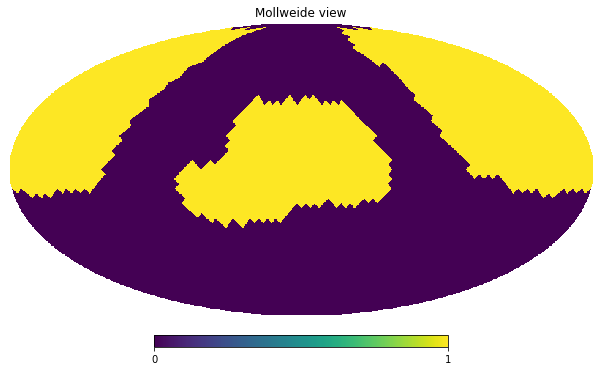

In [31]:
fname_mask = np.zeros(12*16**2)
fname_mask[fname_pix]=1
hp.mollview(fname_mask)

In [3]:
fin = fits.open("/pscratch/sd/q/qhang/desi-lya/results/run-0/catalogue/delta-baseline.fits")
fin[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   56 / length of dimension 1                          
NAXIS2  =              2448986 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    7 / number of table fields                         
TTYPE1  = 'RA      '                                                            
TFORM1  = 'D       '                                                            
TTYPE2  = 'DEC     '                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'Z       '        

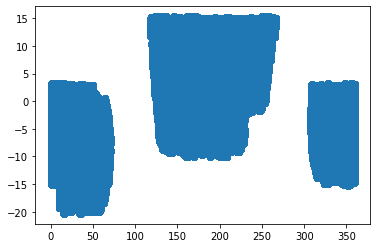

In [4]:
ra = fin[1].data['RA']
dec = fin[1].data['DEC']
pl.scatter(ra, dec)

In [5]:
fin2 = fits.open("/pscratch/sd/q/qhang/desi-lya/delta_F-noise/delta-noisy-overlap-footprint.fits")
fin2[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   48 / length of dimension 1                          
NAXIS2  =              2185229 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    6 / number of table fields                         
TTYPE1  = 'RA      '                                                            
TFORM1  = 'D       '                                                            
TTYPE2  = 'DEC     '                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'Z       '        

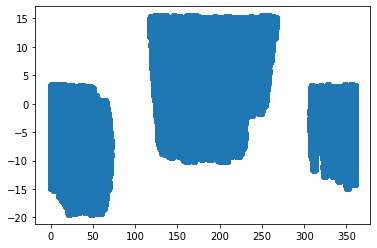

In [7]:
ra = fin2[1].data['RA']
dec = fin2[1].data['DEC']
pl.scatter(ra*180/np.pi, dec*180/np.pi)

In [8]:
fin3 = fits.open("/pscratch/sd/q/qhang/desi-lya/delta_F-noise/delta-noisy-desi-footprint.fits")
#fin3[1].header

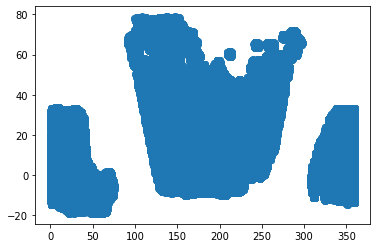

In [9]:
ra = fin3[1].data['RA'][::5]
dec = fin3[1].data['DEC'][::5]
pl.scatter(ra*180/np.pi, dec*180/np.pi)

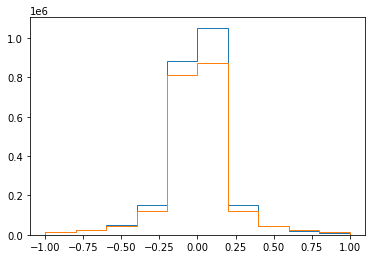

In [20]:
cc=pl.hist(fin[1].data['DELTA_F'],histtype='step',range=[-1,1])
cc=pl.hist(fin2[1].data['DELTA_F'],bins=cc[1],histtype='step')

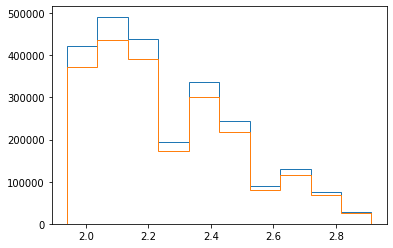

In [17]:
cc=pl.hist(fin[1].data['Z'],histtype='step')
cc=pl.hist(fin2[1].data['Z'],bins=cc[1],histtype='step')

Check corrupted file:

In [6]:
# read in redshift bin somewhere, or save it with the results;
sim_num=2
sim_mode_tag='true_cont'
nchunks = 16

simroot = "/global/cfs/cdirs/desicollab/users/lauracdp/photo-z_box/lya_mocks/mock_analysis/qq_desi_y5/skewers_desi_footprint.5/"
simroot += f"analysis-{sim_num}/jura-0/{sim_mode_tag}/deltas_lya/Delta/"

In [14]:
fname_list = glob(simroot + "*.fits.gz", recursive = True)
print("Total files to go through: ", len(fname_list))
print(f"Splitting into {nchunks} chunks...")
# here, split the file list to chunks and send to different nodes:
Nfiles = int(len(fname_list)/nchunks)+1
fname_chunks = []
for kk in range(nchunks):
    if kk < nchunks - 1 :
        fname_chunks.append(fname_list[(kk*Nfiles):((kk+1)*Nfiles)])
    elif kk == nchunks - 1 :
        fname_chunks.append(fname_list[(kk*Nfiles):])
print(f"Chunk {12} contains {len(fname_chunks[12])} files.")
#print(fname_chunks[12])

# check which file is corrupt:
task=12
error_list = np.array([8])
for mm in range(len(fname_chunks[task])):
    if mm not in error_list:
        hdu = fits.open(fname_chunks[task][mm])
        hdu.close()

Total files to go through:  1244
Splitting into 16 chunks...
Chunk 12 contains 78 files.


In [16]:
8, fname_chunks[task][8]

(8,
 '/global/cfs/cdirs/desicollab/users/lauracdp/photo-z_box/lya_mocks/mock_analysis/qq_desi_y5/skewers_desi_footprint.5/analysis-2/jura-0/true_cont/deltas_lya/Delta/delta-2084.fits.gz')

## cross-check plots:

In [5]:
# for box 0, plot the mean delta f in each redshift bin:

fin = fits.open("/pscratch/sd/q/qhang/desi-lya/results/run-0/catalogue/delta-raw.fits")
fin[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   56 / length of dimension 1                          
NAXIS2  =              2554104 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    7 / number of table fields                         
TTYPE1  = 'RA      '                                                            
TFORM1  = 'D       '                                                            
TTYPE2  = 'DEC     '                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'Z       '        

Text(0, 0.5, 'counts')

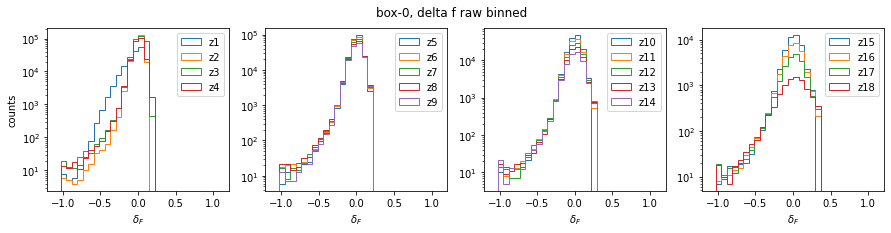

In [20]:
zbins = np.loadtxt("/pscratch/sd/q/qhang/desi-lya/delta_F/zbins.txt")
zbin_edges = zbins[:,0]
#print(len(zbin_edges))

deltaf_raw = fin[1].data['DELTA_F']
totweight_raw = fin[1].data['TOTWEIGHTS']
z = fin[1].data['Z']

fig,axarr=pl.subplots(1,4,figsize=[15,3])

fig.suptitle("box-0, delta f raw binned")


#totflux = np.zeros(len(zbin_edges)-1)
#totweight = np.zeros(len(zbin_edges)-1)

for ii in range(4):
    pl.sca(axarr[ii])
    for jj in range(5):
        kk = ii*5 + jj
        ind = (z>zbin_edges[kk])&(z<=zbin_edges[kk+1])
        if sum(ind)>0:
            cc = pl.hist(deltaf_raw[ind], range=[-1.1,1.1], bins=30, histtype='step', label=f'z{kk}')
            meanflux[kk] = np.mean(deltaf_raw[ind])    
    pl.legend()
    pl.yscale('log')
    pl.xlabel("$\\delta_F$")
pl.sca(axarr[0])
pl.ylabel("counts")

In [26]:
meanflux = np.zeros((len(zbin_edges)-1, 10))
for ii in range(10):
    fin = fits.open(f"/pscratch/sd/q/qhang/desi-lya/results/run-{ii}/catalogue/delta-raw.fits")
    deltaf_raw = fin[1].data['DELTA_F']
    z = fin[1].data['Z']
    for kk in range(len(zbin_edges)-1):
        ind = (z>zbin_edges[kk])&(z<=zbin_edges[kk+1])
        if sum(ind)>0:
            meanflux[kk,ii] = np.mean(deltaf_raw[ind])   

Text(0, 0.5, '$\\langle \\delta_F(z) \\rangle$')

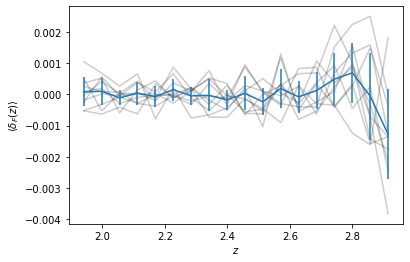

In [28]:
meanmeanflux = np.mean(meanflux,axis=1)
stdmeanflux = np.std(meanflux,axis=1)

for ii in range(10):
    pl.plot(zbins[:-1,1][1:19], meanflux[1:19,ii], 'k-', alpha=0.2)

pl.errorbar(zbins[:-1,1][1:19], meanmeanflux[1:19], yerr=stdmeanflux[1:19])
pl.xlabel("$z$")
pl.ylabel("$\\langle \\delta_F(z) \\rangle$")